### NLP - Homework 8
#### Paritosh Rai¶

In [1]:
# ignore warnnings
#https://queirozf.com/entries/suppressing-ignoring-warnings-in-python-reference-and-examples

import warnings

warnings.filterwarnings('ignore')

# no warnings will be printed from now on


In [2]:
# import required packages
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import itertools
import nltk
from nltk import word_tokenize
import spacy # import spacy
#import required packages
from __future__ import print_function
from nltk import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt #to plot bar chart and heatmap
import pandas as pd
%matplotlib inline
from sklearn.cluster import KMeans
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import re
import os
import matplotlib as mpl
from sklearn.manifold import MDS
from matplotlib import font_manager as rcParams
import itertools
#load en_core_web_sm
nlp = spacy.load('en_core_web_sm')

pd.options.display.max_colwidth=500

In [3]:
def getSoup(url):
    """
    Utility function which takes a url and returns a Soup object.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

In [4]:
# API call to select:
## feature films
## which are rated atleast 4.0
## having atleast 50,000 votes
## in the romance genre
## sorted by user rating
## limit to 150 movies
url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=4.0,10.0
&num_votes=50000,view=simple&sort=user_rating,desc&count=150'''

# get the soup from url using 'getSoup' function
movies_soup = getSoup(url)
# print(movies_soup)

In [76]:
# Find all a-tag with class:None
movie_tags = movies_soup.find_all('a', attrs={'class': None})

#print(movie_tags)

# filter the a-tags to get just the titles
movie_tags = [tag.attrs['href'] for tag in movie_tags 
              if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]
#print(movie_tags)

# remove duplicate links
movie_tags = list(dict.fromkeys(movie_tags))
#print(movie_tags)

#print("There are a total of " + str(len(movie_tags)) + " movie titles")
#print("Displaying 10 titles")

#movie_tags[:10]

In [6]:
# movie links
# use base_url+tag+review
base_url = "https://www.imdb.com"
movie_links = [base_url + tag + 'reviews' for tag in movie_tags]
print("There are a total of " + str(len(movie_links)) + " movie user reviews")
print("Displaying 10 user reviews links")
movie_links[:10]

There are a total of 150 movie user reviews
Displaying 10 user reviews links


['https://www.imdb.com/title/tt0111161/reviews',
 'https://www.imdb.com/title/tt0068646/reviews',
 'https://www.imdb.com/title/tt10189514/reviews',
 'https://www.imdb.com/title/tt0468569/reviews',
 'https://www.imdb.com/title/tt0071562/reviews',
 'https://www.imdb.com/title/tt0050083/reviews',
 'https://www.imdb.com/title/tt0167260/reviews',
 'https://www.imdb.com/title/tt0110912/reviews',
 'https://www.imdb.com/title/tt0108052/reviews',
 'https://www.imdb.com/title/tt1375666/reviews']

In [7]:
# function to find positive and negative review
def minMax(a):
    '''Returns the index of negative and positive review.'''
    
    # get the index of least rated user review
    minpos = a.index(min(a))
    
    # get the index of highest rated user review
    maxpos = a.index(max(a))
    
    return minpos, maxpos

In [8]:
def getReviews(soup):
    '''Function returns a negative and positive review for each movie.'''
    
    # get a list of user ratings
    user_review_ratings = [tag.previous_element for tag in 
                           soup.find_all('span', attrs={'class': 'point-scale'})]
    
    
    # find the index of negative and positive review
    n_index, p_index = minMax(list(map(int, user_review_ratings)))
    
    
    # get the review tags
    user_review_list = soup.find_all('a', attrs={'class':'title'})
    
    
    # get the negative and positive review tags
    n_review_tag = user_review_list[n_index]
    p_review_tag = user_review_list[p_index]
    
    # return the negative and positive review link
    n_review_link = "https://www.imdb.com" + n_review_tag['href']
    p_review_link = "https://www.imdb.com" + p_review_tag['href']
    return n_review_link, p_review_link
    

In [9]:
def getReviewText(review_url):
    '''Returns the user review text given the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find div tags with class text show-more__control
    tag = soup.find('div', attrs={'class': 'text show-more__control'})
    
    return tag.getText()

In [10]:
def getMovieTitle(review_url):
    '''Returns the movie title from the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find h1 tag
    tag = soup.find('h1')
    
    return list(tag.children)[1].getText()

In [11]:
def getNounChunks(user_review):
    
    # create the doc object
    doc = nlp(user_review)
    
    # get a list of noun_chunks
    noun_chunks = list(doc.noun_chunks)
    
    # convert noun_chunks from span objects to strings, otherwise it won't pickle
    noun_chunks_strlist = [chunk.text for chunk in noun_chunks]
    
    return noun_chunks_strlist

In [77]:
# get a list of soup objects
movie_soups = [getSoup(link) for link in movie_links]

# get all 150 movie review links
movie_review_list = [getReviews(movie_soup) for movie_soup in movie_soups]

movie_review_list = list(itertools.chain(*movie_review_list))
print(len(movie_review_list))

print("There are a total of " + str(len(movie_review_list)) + " individual movie reviews")
print("Displaying 10 reviews")
#movie_review_list[:10]

300
There are a total of 300 individual movie reviews
Displaying 10 reviews


In [78]:
# get review text from the review link
review_texts = [getReviewText(url) for url in movie_review_list]

# get movie name from the review link
movie_titles = [getMovieTitle(url) for url in movie_review_list]

# label each review with negative or positive
review_sentiment = np.array(['negative', 'positive'] * (len(movie_review_list)//2))

# construct a dataframe
df = pd.DataFrame({'movie': movie_titles, 'user_review_permalink': movie_review_list,
             'user_review': review_texts, 'sentiment': review_sentiment})

In [79]:
df.head() # ensure all the required fileds are there in right format

,movie,user_review_permalink,user_review,sentiment
0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative
1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive
2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative
3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive
4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative


###### Save Data in harddrive

In [80]:
# save data in CSV file in given location
df.to_csv (r'C:\Paritosh\SMU\DS7337_Natural_Language_Processing\HW\ IMDB.csv', index = False, header=True) # save data frame in csv form

In [81]:
df_csv = pd.read_csv("IMDB.csv") # verify the data is saved 

In [82]:
df_csv.head() # validate the information

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative
3,3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive
4,4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative


In [83]:
df1=df # we will use df1 datafarme for question 1

##### Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:

##### 1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

In [84]:
#Load the spacy's embedded word vector, download the larger spacy english models is used to ensure largest set of words are included.

nlp=spacy.load('en_core_web_lg') 

In [85]:
nltk.download('vader_lexicon') # download vader_lexian
# VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon.
# VADER is rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\parit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [86]:
# import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
sid=SentimentIntensityAnalyzer()

# SentimentIntensityAnalyzer gives a dictionaly of score in four category: 
# Negative, Neutral, posivite and compund score

In [87]:
df1['sentiment'].value_counts() # count number of positive and negative sentiment

positive    150
negative    150
Name: sentiment, dtype: int64

150 samples are postive sentimnet and 150 are negative sentiment

In [88]:
# data clean up if required. Data provided was a clean data 
# Remove na if any
df1.dropna(inplace=True)

###### Validate effectiness of VADR and SentimentIntensityAnalyzer

In [89]:
# read 2nd review:
df1.iloc[0]['user_review']

"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star reviews that I'm seeing and the only reason I am not giving this parable for hope a ten myself is because I don't as a rule.\nHope, aspiration, fighting the system, justice and humanism against the tyranny of the mainstream society/religion. This is the film."

In [90]:
# look at sid ploarity_scores 2nd record
sid.polarity_scores(df1.iloc[1]['user_review'])

{'neg': 0.08, 'neu': 0.714, 'pos': 0.207, 'compound': 0.9939}

Very low negative score (neg), high neutral score (neu) and postive score (pos). Most of it was neutral and some positive. 
Compound score is high (close to 1) and greater than zero. So looks like positove review based on vader SentimentIntensityAnalyzer. It is align with rating by user.

In [91]:
# Apply this to dataframe and add polarity score as score
df1['scores'] = df1['user_review'].apply(lambda user_review: sid.polarity_scores(user_review))

In [92]:
# check first place
df1.head()
# new column is added a disctionary with four scores

,movie,user_review_permalink,user_review,sentiment,scores
0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"{'neg': 0.061, 'neu': 0.77, 'pos': 0.169, 'compound': 0.9318}"
1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"{'neg': 0.08, 'neu': 0.714, 'pos': 0.207, 'compound': 0.9939}"
2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"{'neg': 0.051, 'neu': 0.81, 'pos': 0.138, 'compound': 0.9984}"
3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive,"{'neg': 0.106, 'neu': 0.711, 'pos': 0.183, 'compound': 0.9897}"
4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative,"{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compound': 0.8268}"


In [93]:
# We will leverage compund score to udentify sentiments
# add a column with compound score to dataframe from the dictionary

df1['compound'] = df1['scores'].apply(lambda d:d['compound'])


In [94]:
# check the 1st 5 samples
df1.head()

,movie,user_review_permalink,user_review,sentiment,scores,compound
0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"{'neg': 0.061, 'neu': 0.77, 'pos': 0.169, 'compound': 0.9318}",0.9318
1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"{'neg': 0.08, 'neu': 0.714, 'pos': 0.207, 'compound': 0.9939}",0.9939
2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"{'neg': 0.051, 'neu': 0.81, 'pos': 0.138, 'compound': 0.9984}",0.9984
3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive,"{'neg': 0.106, 'neu': 0.711, 'pos': 0.183, 'compound': 0.9897}",0.9897
4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative,"{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compound': 0.8268}",0.8268


In [95]:
#use compound score to determine comp_score
# of value of compund is equal to or greater than zero call it postive soce, else negative (i.e. comp_score <0)
df1['comp_score']=df1['compound'].apply(lambda score:'positive' if score >=0 else 'negative')

In [96]:
#list 1st few rows of dataframe
df1.head()

,movie,user_review_permalink,user_review,sentiment,scores,compound,comp_score
0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"{'neg': 0.061, 'neu': 0.77, 'pos': 0.169, 'compound': 0.9318}",0.9318,positive
1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"{'neg': 0.08, 'neu': 0.714, 'pos': 0.207, 'compound': 0.9939}",0.9939,positive
2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"{'neg': 0.051, 'neu': 0.81, 'pos': 0.138, 'compound': 0.9984}",0.9984,positive
3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive,"{'neg': 0.106, 'neu': 0.711, 'pos': 0.183, 'compound': 0.9897}",0.9897,positive
4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative,"{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compound': 0.8268}",0.8268,positive


In [97]:
# validate the accuracy
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

###### Accuracy Sentiment vs comp_score

In [33]:
accuracy_score(df1['sentiment'],df1['comp_score'])

0.5433333333333333

55% is a  low accuracy score. However, better than 50%. Sometimes it is a bit hard to read and understand what users are saying, and sometimes it's also sarcastic, which makes it's tough to detect. Sarcasm is almost impossible to test for something like VADER. Few cases were observed where sentiment rating was not aligning with the text reviews. The reviews were excellent, but the rating was low, and the compound score aligns with the review. After reading the reviews, we have observed the review and compound score align well.

###### Classification Report

In [34]:
print(classification_report(df1['sentiment'],df1['comp_score']))

              precision    recall  f1-score   support

    negative       0.62      0.22      0.33       150
    positive       0.53      0.87      0.65       150

    accuracy                           0.54       300
   macro avg       0.57      0.54      0.49       300
weighted avg       0.57      0.54      0.49       300



The classification report aligns with the observation that a lot of negative sentiments are analyzed as positive. 

###### Distribution of postive and negative scores by sentimentIntensityAnalyzer

In [98]:
df1['comp_score'].value_counts()

positive    247
negative     53
Name: comp_score, dtype: int64

SentimentAnalyzer identified a low number of negative scores, whereas sentiments were equally distributed in the original dataframe. After reading the reviews and comparing them with sentiments and compound scores, it is evident that SentimentAnalyzer is doing a good job identifying the reviews as positive or negative. 

###### Confusion Matrix

In [99]:
print(confusion_matrix(df1['sentiment'],df1['comp_score']))

[[ 33 117]
 [ 20 130]]


Aligns with positive and negative distribution above

##### 2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

In [125]:
# df2 data frame will be used to recreate the cluster of HW5.
df2= pd.read_csv("IMDB.csv") # reterive IMDB date from hard drive as df2

In [126]:
df2.head() # valdiate data for right format

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative
3,3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive
4,4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative


In [127]:
df2.shape # number of rows and columns in dataframe

(300, 5)

In [128]:
user_review = df2.user_review # pull user_review

In [129]:
user_review.shape # validate number of rows

(300,)

In [130]:
#Text Preprocessing
# remove stip words, normalize, tokenize
#load stop word libary
stop_words = nltk.corpus.stopwords.words('english')
# define the function to normalize the text
def normalize_document(doc):
 # lower case and remove special characters\whitespaces
 doc = re.sub(r'[^a-zA-Z0-9\s]',"",doc, re.I|re.A) # remove special characters and white space
 doc = doc.lower() # lower case
 doc = doc.strip()
 # tokenize document
 tokens = nltk.word_tokenize(doc)
 # filter stopwords out of document
 filtered_tokens = [token for token in tokens if token not in stop_words]
 # re-create document from filtered tokens
 doc = ' '.join(filtered_tokens)
 return doc
#normailize the text
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(user_review)
tokens = nltk.word_tokenize('norm_corpus')
len(norm_corpus) # check lenght to ensure there is data in the tozanized text

300

In [131]:
#norm_corpus

In [132]:
#  leverage TF_IDF to vectorize our preprocessed movie descriptions, thereby converting them into numeric vectors
#define vectorizer parameters

vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, max_features=200000, min_df=0.10)
reviews_tfidf_matrix = vec.fit_transform(norm_corpus) #fit the vectorizer to synopses
reviews_tfidf_matrix.shape # check shape to valiadate data in matrix

(300, 212)

In [133]:
#gather the different terms from the TF-IDF matrix and calculate cosine similarity distances based on the matrix.
terms = vec.get_feature_names()
dist = 1 - cosine_similarity(reviews_tfidf_matrix)

In [134]:
MDS()
# convert two components as we're plotting points in a two-dimensional plane leveraging MDS (Multidimenstional scaling)
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
#pos

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(300, 916)

In [136]:
#print(reviews_tfidf_matrix)

In [137]:
#print(cv_matrix)

In [138]:
# K- Mean Clustering
# three cluster
from sklearn.cluster import KMeans
NUM_CLUSTERS = 3 # number of cluster
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cv_matrix)
km
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
 n_clusters=NUM_CLUSTERS, n_init=50, n_jobs=None, precompute_distances='auto',
 random_state=42, tol=0.0001, verbose=0)
norm_corpus= km.labels_
#km

In [139]:
#norm_corpus

In [140]:
#km.labels_

In [141]:
# viewing distribution of movies across the clusters
from collections import Counter
Counter(km.labels_)

Counter({0: 203, 2: 32, 1: 65})

In [142]:
#  to group similar movies in clusters

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_features = cosine_similarity(cv_matrix)
km = KMeans(n_clusters=NUM_CLUSTERS , max_iter=100000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)
Counter({4: 427, 3: 724, 1: 1913, 2: 504, 0: 879, 5: 353})
df2['kmeans_cluster'] = km.labels_
movie_clusters = (df2[['movie', 'kmeans_cluster']]
 .sort_values(by=['kmeans_cluster'],
 ascending=False)
 .groupby('kmeans_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS ):
 movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['movie'].values.tolist()
 print('CLUSTER #'+str(cluster_num+1))
 print('Popular Movies:', movies)
 print('-'*80)

CLUSTER #1
Popular Movies: ['Heat', 'Lawrence of Arabia', 'Vertigo', 'Vertigo', 'North by Northwest', 'There Will Be Blood', 'Batman Begins', 'Lawrence of Arabia', 'Up', 'L.A. Confidential', 'Shutter Island', 'Swades', "Pan's Labyrinth", 'Lock, Stock and Two Smoking Barrels', 'Queen', 'A Beautiful Mind', 'Green Book', 'A Beautiful Mind', 'The Kid', 'The Kid']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Movies: ['Aliens', 'Witness for the Prosecution', 'A Separation', 'The Hunt', 'Metropolis', 'The Great Dictator', 'The Great Dictator', 'Sunset Blvd.', 'Andhadhun', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Fellowship of the Ring', 'Soorarai Pottru', 'Alien', 'Forrest Gump', 'A Silent Voice: The Movie', 'A Clockwork Orange', 'The Good, the Bad and the Ugly', 'The Shining', 'Indiana Jones and the Raiders of the Lost Ark', '2001: A Space Odyssey']
-------------------------------------------------

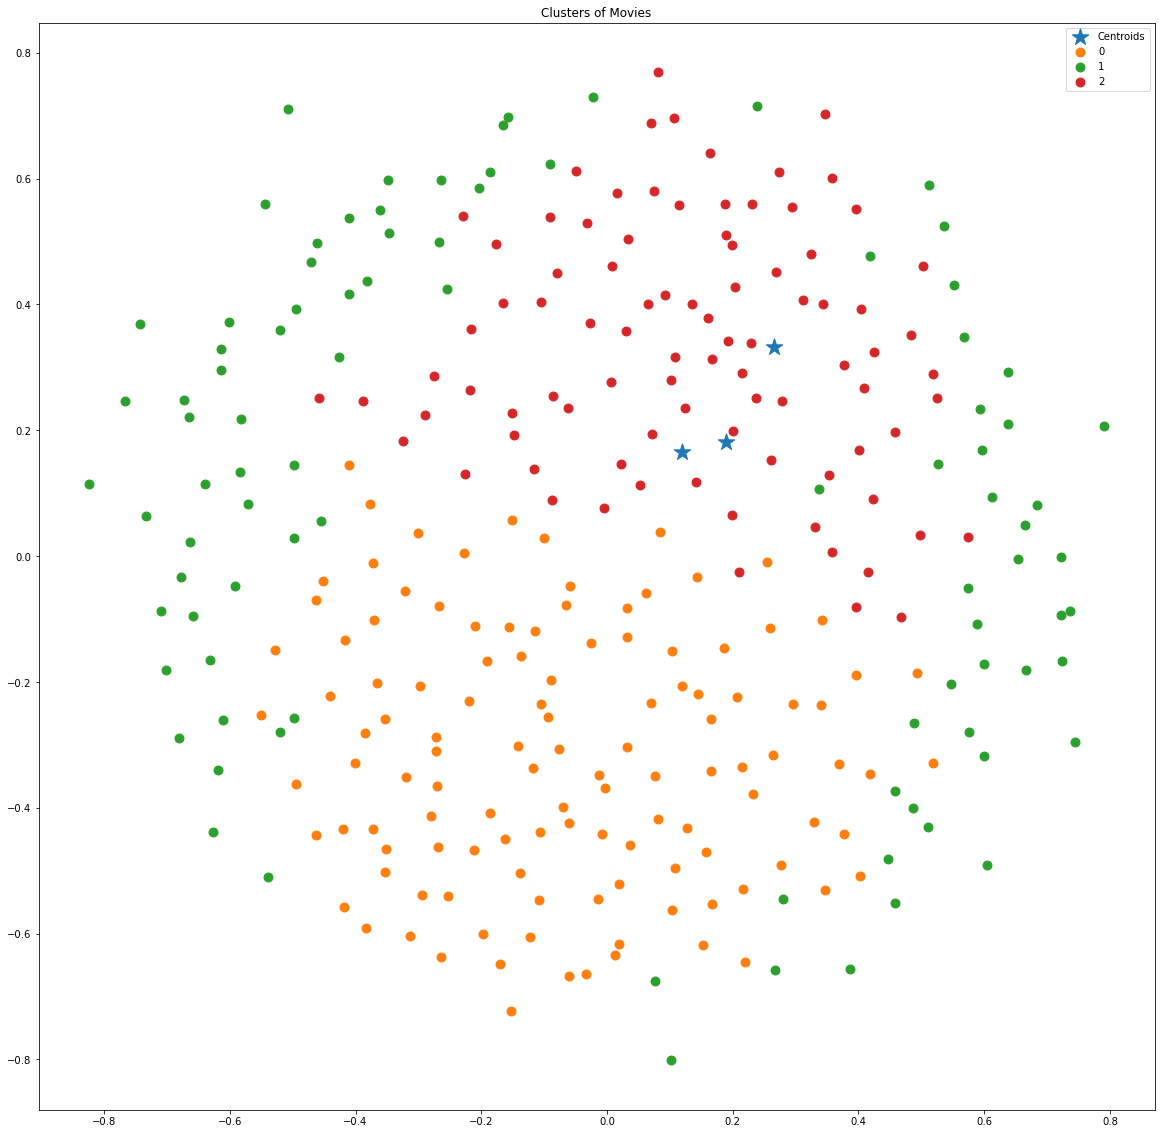

In [143]:
#plotting of Movie Cluster Map
plt.figure(figsize=(20, 20))
#filter rows of original data
filtered_label0 = pos[km.labels_== 0]
filtered_label1 = pos[km.labels_== 1]
filtered_label2 = pos[km.labels_== 2]

#Plotting the results#plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.title('Clusters of Movies')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, label = 'Centroids', marker="*")
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], s=80, label = '0')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], s=80, label = '1')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], s=80, label = '2')
plt.legend()
plt.show()

In [144]:
df2.pop('kmeans_cluster') # remove  kmean_cluster column
df2.head()

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative
3,3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive
4,4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative


In [145]:
df1['cluster'] = km.labels_.tolist() # Add cluster to df1 dataframe

In [146]:
#df1.head() # validate the outcome

In [147]:
# Calculate mean, min, max and median pf compound grouped by cluster
result = df1.groupby('cluster').agg({'compound': ['mean', 'min', 'max','median']})

In [148]:
print('mean, min, max and median score for each cluster \n')
print ('\n')
print(result)

mean, min, max and median score for each cluster 



         compound                         
             mean     min     max   median
cluster                                   
0        0.599891 -0.9997  0.9995  0.97705
1        0.560969 -0.9986  0.9978  0.93300
2        0.689564 -0.9981  0.9996  0.98460


Following are my observations about three clusters:

    *All three clusters have extremely negative and extremely positive sentiment by looking at min and max values
    
    *Looking at mean sentiments, cluster 2 has more positive sentiment on average than cluster 0 and cluster 1
    
    *All three clusters, on average, are positive clusters
    
    *All three clusters have a lot of extremely positive sentiments based on the median.

##### 3.	For extra credit, analyze sentiment of chunks as follows:
##### a.	Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).


In [149]:
# Pull the IMDB date from CSV file for further analysis.
df3 = pd.read_csv("IMDB.csv") 
#df3.head()

In [150]:
# convert user_review to noun chunks
# add the noun chunks as column in dataframe
df3['noun_chunks'] = df3['user_review'].apply(getNounChunks)
df3.head()

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"[You, It, the love, this movie, I, it, movie adaptations, books, the book, it, You, way more detail, a two-hour movie, I, this adaptation, it, character changes, omissions, I, this film, I, line, the ten-star reviews, I, the only reason, I, this parable, hope, I, a rule, Hope, aspiration, the system, justice, humanism, the tyranny, the mainstream society/religion, the film]"
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"[I, the 234th comment, The Shawshank Redemption, I, almost everything, it, so many other people, who, comments, I, this simple and eloquent depiction, hope, friendship, redemption, The only other movie, I, me, a Mockingbird, Both movies, me, them, I, this movie, I, prison movies, I, them, I, a branch library, I, The Shawshank Redemption, our older patrons, she, me, I, I, this movie, it, it, me, the time, I, nothing, TV, things, I, any circumstance, things, I, too many times, I, what, she, I,..."
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"[The Godfather, the greatest films, all time, The script, thee, I, The direction, The acting, the best ensemble, any movie, I, It, the most precise and intricate films, I, writer, Mario Puzo, the most hidden and guarded secrets, the underground world, film, The Godfather, cinematic art, Francis Ford Coppola's direction, what, this film, earth, precision direction, he, each and every scene, such care, The film, a black screen, an opening monologue, an undertaker, the man, honor, family, respe..."
3,3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive,"[The Godfather, the pinnacle, flawless films, The first time, I, The Godfather' I, my early teens, it, the most astounding film, I, my all-time favourite film, It, I, a review, this unforgettable classic, 's, the beginning, The film, four words

In [151]:
# convert noun_chunk_mod as string from noun_chunk list
df3['noun_chunk_mod'] = [','.join(map(str, l)) for l in df3['noun_chunks']]
df3.head()


,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"[You, It, the love, this movie, I, it, movie adaptations, books, the book, it, You, way more detail, a two-hour movie, I, this adaptation, it, character changes, omissions, I, this film, I, line, the ten-star reviews, I, the only reason, I, this parable, hope, I, a rule, Hope, aspiration, the system, justice, humanism, the tyranny, the mainstream society/religion, the film]","You,It,the love,this movie,I,it,movie adaptations,books,the book,it,You,way more detail,a two-hour movie,I,this adaptation,it,character changes,omissions,I,this film,I,line,the ten-star reviews,I,the only reason,I,this parable,hope,I,a rule,Hope,aspiration,the system,justice,humanism,the tyranny,the mainstream society/religion,the film"
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"[I, the 234th comment, The Shawshank Redemption, I, almost everything, it, so many other people, who, comments, I, this simple and eloquent depiction, hope, friendship, redemption, The only other movie, I, me, a Mockingbird, Both movies, me, them, I, this movie, I, prison movies, I, them, I, a branch library, I, The Shawshank Redemption, our older patrons, she, me, I, I, this movie, it, it, me, the time, I, nothing, TV, things, I, any circumstance, things, I, too many times, I, what, she, I,...","I,the 234th comment,The Shawshank Redemption,I,almost everything,it,so many other people,who,comments,I,this simple and eloquent depiction,hope,friendship,redemption,The only other movie,I,me,a Mockingbird,Both movies,me,them,I,this movie,I,prison movies,I,them,I,a branch library,I,The Shawshank Redemption,our older patrons,she,me,I,I,this movie,it,it,me,the time,I,nothing,TV,things,I,any circumstance,things,I,too many times,I,what,she,I,it,I,it,it,every showing,No action,no special effects,..."
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"[The Godfather, the greatest films, all time, The script, thee, I, The direction, The acting, the best ensemble, any movie, I, It, the most precise and intricate films, I, writer, Mario Puzo, the most hidden and guarded secrets, the underground world, film, The Godfather, cinematic art, Francis Ford Coppola's direction, what, this film, earth, precision direction, he, each and every scene, such care, The film, a black screen, an opening monologue, an un

In [152]:
# Apply this noun_chunk_mod in dataframe as polarity score in column scores_nc

df3['scores_nc'] = df3['noun_chunk_mod'].apply(lambda noun_chunk_mod: sid.polarity_scores(noun_chunk_mod))
df3.head()

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod,scores_nc
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"[You, It, the love, this movie, I, it, movie adaptations, books, the book, it, You, way more detail, a two-hour movie, I, this adaptation, it, character changes, omissions, I, this film, I, line, the ten-star reviews, I, the only reason, I, this parable, hope, I, a rule, Hope, aspiration, the system, justice, humanism, the tyranny, the mainstream society/religion, the film]","You,It,the love,this movie,I,it,movie adaptations,books,the book,it,You,way more detail,a two-hour movie,I,this adaptation,it,character changes,omissions,I,this film,I,line,the ten-star reviews,I,the only reason,I,this parable,hope,I,a rule,Hope,aspiration,the system,justice,humanism,the tyranny,the mainstream society/religion,the film","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"[I, the 234th comment, The Shawshank Redemption, I, almost everything, it, so many other people, who, comments, I, this simple and eloquent depiction, hope, friendship, redemption, The only other movie, I, me, a Mockingbird, Both movies, me, them, I, this movie, I, prison movies, I, them, I, a branch library, I, The Shawshank Redemption, our older patrons, she, me, I, I, this movie, it, it, me, the time, I, nothing, TV, things, I, any circumstance, things, I, too many times, I, what, she, I,...","I,the 234th comment,The Shawshank Redemption,I,almost everything,it,so many other people,who,comments,I,this simple and eloquent depiction,hope,friendship,redemption,The only other movie,I,me,a Mockingbird,Both movies,me,them,I,this movie,I,prison movies,I,them,I,a branch library,I,The Shawshank Redemption,our older patrons,she,me,I,I,this movie,it,it,me,the time,I,nothing,TV,things,I,any circumstance,things,I,too many times,I,what,she,I,it,I,it,it,every showing,No action,no special effects,...","{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.9741}"
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"[The Godfather, the greatest films, all time, The script, thee, I, The direction, The acting, the best ensemble, any movie, I, It, the most precise and intricate films, I, writer, Mario Puzo, the most hidden and guarded secrets, the underground world, film, The Godfather, cinematic art, Francis Ford Coppola's direction, what, 

In [153]:
# We will leverage compund score to identify sentiments
# add a column with compound score (compound_nc) to dataframe from the dictionary

df3['compound_nc'] = df3['scores_nc'].apply(lambda d:d['compound'])
df3.head()

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod,scores_nc,compound_nc
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"[You, It, the love, this movie, I, it, movie adaptations, books, the book, it, You, way more detail, a two-hour movie, I, this adaptation, it, character changes, omissions, I, this film, I, line, the ten-star reviews, I, the only reason, I, this parable, hope, I, a rule, Hope, aspiration, the system, justice, humanism, the tyranny, the mainstream society/religion, the film]","You,It,the love,this movie,I,it,movie adaptations,books,the book,it,You,way more detail,a two-hour movie,I,this adaptation,it,character changes,omissions,I,this film,I,line,the ten-star reviews,I,the only reason,I,this parable,hope,I,a rule,Hope,aspiration,the system,justice,humanism,the tyranny,the mainstream society/religion,the film","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"[I, the 234th comment, The Shawshank Redemption, I, almost everything, it, so many other people, who, comments, I, this simple and eloquent depiction, hope, friendship, redemption, The only other movie, I, me, a Mockingbird, Both movies, me, them, I, this movie, I, prison movies, I, them, I, a branch library, I, The Shawshank Redemption, our older patrons, she, me, I, I, this movie, it, it, me, the time, I, nothing, TV, things, I, any circumstance, things, I, too many times, I, what, she, I,...","I,the 234th comment,The Shawshank Redemption,I,almost everything,it,so many other people,who,comments,I,this simple and eloquent depiction,hope,friendship,redemption,The only other movie,I,me,a Mockingbird,Both movies,me,them,I,this movie,I,prison movies,I,them,I,a branch library,I,The Shawshank Redemption,our older patrons,she,me,I,I,this movie,it,it,me,the time,I,nothing,TV,things,I,any circumstance,things,I,too many times,I,what,she,I,it,I,it,it,every showing,No action,no special effects,...","{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.9741}",0.9741
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"[The Godfather, the greatest films, all time, The script, thee, I, The direction, The acting, the best ensemble, any movie, I, It, the most precise and intricate films, I, writer, Mario Puzo, the most hidden and guarded secrets, the underground world, film, The Godfather, cinematic art, Francis Ford C

In [154]:
#use compound_nc to determine sentiment of noun chunk _score_nc
# If value of compund_nc is equal to or greater than zero call it postive soce, else negative (i.e. comp_score <0)
df3['comp_score_nc']=df3['compound_nc'].apply(lambda score:'positive' if score >=0 else 'negative')
df3.head()

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod,scores_nc,compound_nc,comp_score_nc
0,0,The Shawshank Redemption,https://www.imdb.com/review/rw6627363/,"You have already watched this, right?\nIt is really easy to understand the love for this movie. I'll admit, when it comes to movie adaptations of books, the book is always better. How can it not be? You get way more detail than could be crammed into a two-hour movie. However, I still thoroughly enjoyed this adaptation. Yes, it does deviate from the short a little with character changes and omissions, but I don't think this film could have been any better. I am in line with the ten-star revie...",negative,"[You, It, the love, this movie, I, it, movie adaptations, books, the book, it, You, way more detail, a two-hour movie, I, this adaptation, it, character changes, omissions, I, this film, I, line, the ten-star reviews, I, the only reason, I, this parable, hope, I, a rule, Hope, aspiration, the system, justice, humanism, the tyranny, the mainstream society/religion, the film]","You,It,the love,this movie,I,it,movie adaptations,books,the book,it,You,way more detail,a two-hour movie,I,this adaptation,it,character changes,omissions,I,this film,I,line,the ten-star reviews,I,the only reason,I,this parable,hope,I,a rule,Hope,aspiration,the system,justice,humanism,the tyranny,the mainstream society/religion,the film","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,positive
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"[I, the 234th comment, The Shawshank Redemption, I, almost everything, it, so many other people, who, comments, I, this simple and eloquent depiction, hope, friendship, redemption, The only other movie, I, me, a Mockingbird, Both movies, me, them, I, this movie, I, prison movies, I, them, I, a branch library, I, The Shawshank Redemption, our older patrons, she, me, I, I, this movie, it, it, me, the time, I, nothing, TV, things, I, any circumstance, things, I, too many times, I, what, she, I,...","I,the 234th comment,The Shawshank Redemption,I,almost everything,it,so many other people,who,comments,I,this simple and eloquent depiction,hope,friendship,redemption,The only other movie,I,me,a Mockingbird,Both movies,me,them,I,this movie,I,prison movies,I,them,I,a branch library,I,The Shawshank Redemption,our older patrons,she,me,I,I,this movie,it,it,me,the time,I,nothing,TV,things,I,any circumstance,things,I,too many times,I,what,she,I,it,I,it,it,every showing,No action,no special effects,...","{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.9741}",0.9741,positive
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"[The Godfather, the greatest films, all time, The script, thee, I, The direction, The acting, the best ensemble, any movie, I, It, the most precise and intricate films, I, writer, Mario Puzo, the most hidden and guarded secrets, the underground world, film, The Godfathe

###### Calculate accuracy score comparing ratings (sentiment) with comp_score_nc

In [155]:
accuracy_score(df3['sentiment'],df3['comp_score_nc'])

0.5166666666666667

Accuracy calculated using noun chunk  is lower than accuracy calculated using user_review

###### Calculate accuracy score comparing comp_score (compound score from user_review) and comp_score_nc (compound score from noun Chunk). 

In [156]:
accuracy_score(df1['comp_score'],df3['comp_score_nc'])

0.8

There is a good alignment between acurracy calcualted using analyzer from user_review and none chunks

###### We will filter out the neutral phrases from above data set to focus our analysis on positive or negative phrases.

In [157]:
np.shape(df3)

(300, 10)

In [158]:
df_chunk_scores_non_zero = df3[df3.compound_nc != 0] # keep only records that have non-zero compund_nc
df_chunk_scores_non_zero.head()

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod,scores_nc,compound_nc,comp_score_nc
1,1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive,"[I, the 234th comment, The Shawshank Redemption, I, almost everything, it, so many other people, who, comments, I, this simple and eloquent depiction, hope, friendship, redemption, The only other movie, I, me, a Mockingbird, Both movies, me, them, I, this movie, I, prison movies, I, them, I, a branch library, I, The Shawshank Redemption, our older patrons, she, me, I, I, this movie, it, it, me, the time, I, nothing, TV, things, I, any circumstance, things, I, too many times, I, what, she, I,...","I,the 234th comment,The Shawshank Redemption,I,almost everything,it,so many other people,who,comments,I,this simple and eloquent depiction,hope,friendship,redemption,The only other movie,I,me,a Mockingbird,Both movies,me,them,I,this movie,I,prison movies,I,them,I,a branch library,I,The Shawshank Redemption,our older patrons,she,me,I,I,this movie,it,it,me,the time,I,nothing,TV,things,I,any circumstance,things,I,too many times,I,what,she,I,it,I,it,it,every showing,No action,no special effects,...","{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.9741}",0.9741,positive
2,2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative,"[The Godfather, the greatest films, all time, The script, thee, I, The direction, The acting, the best ensemble, any movie, I, It, the most precise and intricate films, I, writer, Mario Puzo, the most hidden and guarded secrets, the underground world, film, The Godfather, cinematic art, Francis Ford Coppola's direction, what, this film, earth, precision direction, he, each and every scene, such care, The film, a black screen, an opening monologue, an undertaker, the man, honor, family, respe...","The Godfather,the greatest films,all time,The script,thee,I,The direction,The acting,the best ensemble,any movie,I,It,the most precise and intricate films,I,writer,Mario Puzo,the most hidden and guarded secrets,the underground world,film,The Godfather,cinematic art,Francis Ford Coppola's direction,what,this film,earth,precision direction,he,each and every scene,such care,The film,a black screen,an opening monologue,an undertaker,the man,honor,family,respect,justice,we,his luminous eyes,he,da...","{'neg': 0.006, 'neu': 0.891, 'pos': 0.104, 'compound': 0.9746}",0.9746,positive
3,3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ..

In [159]:
np.shape(df_chunk_scores_non_zero)

(280, 10)

~20 rows we removed from data frame. 

##### b.	Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 


##### Highest negative-sentiment-scoring chunks noun phrases.

In [160]:
df_chunk_scores_non_zero.nsmallest(10, 'compound_nc')

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod,scores_nc,compound_nc,comp_score_nc
193,193,Reservoir Dogs,https://www.imdb.com/review/rw0311912/,"Reservoir Dogs is a testament to the idea that ""less is more."" This doesn't apply to the violence, the film is extremely violent from beginning to end, but the details of the botched diamond heist, which the entire film is based on, are conveyed only in the dialogue, except for one scene where Mr. Pink (Steve Buscemi) recalls his escape. The whole film takes place after the failed robbery is over, and the mystery that unfolds among the criminal participants is amazing to watch. This is not a...",positive,"[Reservoir Dogs, a testament, the idea, the violence, the film, the details, the botched diamond heist, the entire film, the dialogue, one scene, Mr. Pink, Steve Buscemi, his escape, The whole film, place, the failed robbery, the mystery, the criminal participants, a normal crime film, The thing, Reservoir Dogs, the others, it, you, the screen, you, reality, no Hollywood actors, no make-up, them, no comic relief, no goofy romantic subplot, a detrimental trademark, so many action films, virtu...","Reservoir Dogs,a testament,the idea,the violence,the film,the details,the botched diamond heist,the entire film,the dialogue,one scene,Mr. Pink,Steve Buscemi,his escape,The whole film,place,the failed robbery,the mystery,the criminal participants,a normal crime film,The thing,Reservoir Dogs,the others,it,you,the screen,you,reality,no Hollywood actors,no make-up,them,no comic relief,no goofy romantic subplot,a detrimental trademark,so many action films,virtually all Jerry Bruckheimer films,th...","{'neg': 0.268, 'neu': 0.66, 'pos': 0.072, 'compound': -0.9788}",-0.9788,negative
272,272,There Will Be Blood,https://www.imdb.com/review/rw1796522/,"First off, I'd like to say that I have enjoyed most all of PTA's films. I loved Boogie Nights, thought Magnolia was an ambitious, but not great picture, and thoroughly enjoyed Punch- Drunk Love. I, like many others have eagerly awaited Paul Thomas Anderson's latest film, There Will Be Blood. In fact, I drove almost 120 miles and waited 2-3 hours in line to see it, as that was the closest showing of it. I bought into all the hype, read almost every review, watched any and all interviews of it...",negative,"[I, I, PTA's films, I, Boogie Nights, Magnolia, an ambitious, but not great picture, Punch- Drunk Love, I, many others, Paul Thomas Anderson's latest film, Blood, fact, I, almost 120 miles, 2-3 hours, line, it, the closest showing, it, I, all the hype, almost every review, all interviews, it, I, a ""masterpiece, so many IMDBers, it, People, the audacity, it, the best films, the decade, Some big words, shoes, a film, the wait, I, myself, this film, The movie's pacing, editing, SO slow and too ...","I,I,PTA's films,I,Boogie Nights,Magnolia,an ambitious, but not great picture,Punch- Drunk Love,I,many others,Paul Thomas Anderson's latest film,Blood,fact,I,almost 120 miles,2-3 hours,line,it,the closest showing,it,I,all the hype,almost every review,all interviews,it,I,a ""masterpiece,so many IMDBers,it,People,the audacity,it,the best films,the decade,Some big words,shoes,a film,the wait,I,myself,this film,The movie's pacing,editing,SO slow and too long (nearly 3 hours,I,the editor,another mu...","{'neg': 0.152, 'neu': 0.798, 'pos': 0.05, 'compound': -0.9781}",-0.9781,negative
195,195,Full Metal Jacket,https://www.imdb.com/review/rw3335538/,"SPOILER: Full Metal Jacket is a 1987 realistic Vietnam war film and is one of the best films of the 80's ever made, directed and produced by Stanley Kubrick. The screenplay by Kubrick, Michael Herr, and Gustav Hasford was based on Hasford's novel The Short-Timers (1979). Full Metal jacket (1987) was Nominated for 1 Oscar. Another 7 wins & 9 nominations. It is one of my personal favorite war movies. I love this movie to death. A superb ensemble falls in for for Stanley Kubrick's

Indeed, we see many negative words like failed, not great, bombing, boring moment, nothing, spoilers, and many more. However, some of the comments were there giving a summary of the movie and used negative words. 

##### Highest positive-sentiment-scoring chunks

In [161]:
df_chunk_scores_non_zero.nlargest(10, 'compound_nc')

,Unnamed: 0,movie,user_review_permalink,user_review,sentiment,noun_chunks,noun_chunk_mod,scores_nc,compound_nc,comp_score_nc
91,91,Back to the Future,https://www.imdb.com/review/rw3686847/,"What can I say about this movie that was already said? It is my favorite time travel sci-fi, adventure epic comedy in the 80's and I love this movie to death! When I saw this movie I was thrown out by its theme. An excellent sci-fi, adventure epic, I LOVE the 80s. It's simple the greatest time travel movie ever happened in the history of world cinema. I love this movie to death, I love, LOVE, love it! I firstly saw this movie in the early 90's as a kid on VHS tape and I was blow away by the ...",positive,"[What, I, this movie, It, my favorite time travel sci-fi, adventure epic comedy, I, this movie, death, I, this movie, I, its theme, An excellent sci-fi, adventure epic, I, the 80s, It, the greatest time travel movie, the history, world cinema, I, this movie, death, I, LOVE, it, I, this movie, a kid, VHS tape, I, the action, the score, the title, the future, This movie, the best masterpiece time travel epic adventure film, Michael J. Fox, Christopher Lloyd, acting, Music theme score, Alan Sil...","What,I,this movie,It,my favorite time travel sci-fi,adventure epic comedy,I,this movie,death,I,this movie,I,its theme,An excellent sci-fi,adventure epic,I,the 80s,It,the greatest time travel movie,the history,world cinema,I,this movie,death,I,LOVE,it,I,this movie,a kid,VHS tape,I,the action,the score,the title,the future,This movie,the best masterpiece time travel epic adventure film,Michael J. Fox,Christopher Lloyd,acting,Music theme score,Alan Silvestri,I,it,the Future,the Academy Award ""-...","{'neg': 0.024, 'neu': 0.701, 'pos': 0.274, 'compound': 0.9975}",0.9975,positive
87,87,Cinema Paradiso,https://www.imdb.com/review/rw1024609/,"It is by now well known that there are two versions of this film that differ greatly, the original 3 hour Italian cut and the heavily re-edited 2 hour version which was the version that charmed the world in 1989. It remains a wonderful experience, but the director's cut is so much richer, deeper, satisfying,well,everything. This review is of the director's cut which may not be the greatest film in the world but is my favourite film of all time ever since I came out of the cinema in which I f...",positive,"[It, two versions, this film, the version, the world, It, a wonderful experience, the director's cut, so much richer, deeper, satisfying,well,everything, This review, the director's cut, the greatest film, the world, my favourite film, all time, I, the cinema, I, it, my eyes, a film, me, this one, Cinema Paradiso, a touching story, a friendship, a wonderful portrayal, a Sicilian village, a loving tribute, the cinema, other things, I, the most moving and romantic love story, my money, you, Ca...","It,two versions,this film,the version,the world,It,a wonderful experience,the director's cut,so much richer, deeper, satisfying,well,everything,This review,the director's cut,the greatest film,the world,my favourite film,all time,I,the cinema,I,it,my eyes,a film,me,this one,Cinema Paradiso,a touching story,a friendship,a wonderful portrayal,a Sicilian village,a loving tribute,the cinema,other things,I,the most moving and romantic love story,my money,you,Casablanca,Dr Zhivago,Titanic,Romeo,Ju...","{'neg': 0.033, 'neu': 0.696, 'pos': 0.271, 'compound': 0.9967}",0.9967,positive
175,175,Eternal Sunshine of the Spotless Mind,https://www.imdb.com/review/rw0902240/,"How happy is the blameless vestal's lot! The world forgetting, by the world forgot. Eternal sunshine of the spotless mind! Each pray'r accepted, and each wish resign'd. -- Alexander Pope==> I confess to being an idealist and a romantic. This type of film appeals to people like me... the ones who believe in love at first sight, soul mates, destiny, yada yada yada. The Charlie Kaufman penned 'Eternal Sunshine of the Spotless Mind' is as fresh and original as some of hi

Indeed, we see many positive words like Award, my favorite, wonderful experience, spotless, blameless, beautiful, stylish, and many more. However, some of the comments were there, giving a summary of the movie and used positive words. Although overall these reviews were positive reviews.